# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [2]:
%load_ext autoreload
%autoreload 2

In [12]:
!pip install transformers


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [13]:
import torch
from tqdm import tqdm
import numpy as np
from dataset import TextDataset
from model import LanguageModel
from train import train
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import seaborn as sns

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [37]:
!pip install sentencepiece

In [39]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', max_length=512)

In [15]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [16]:
model = LanguageModel(train_set)

In [17]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

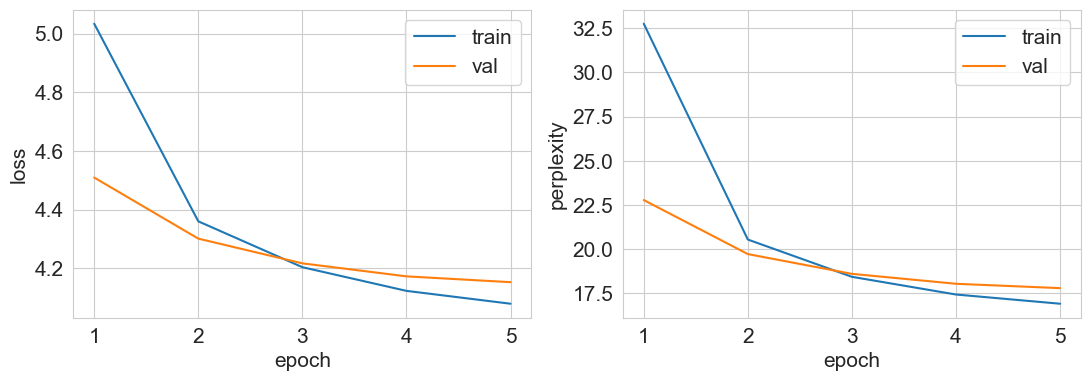

Generation examples:
0 запись вырудили туда-филмывать, в тебе, оленьму за 2500 ⁇ .- айчас дело смирий ты все-бельчик.- ага, мне постоянно телефонные, чем все дыраливается.
1 маленький мальчик спрашивает жену- ну почему?- нет, эта стоят пять таким плохие то страшным!
2 никогда не разбирает снять ударов неудобно зажащаются, но еще много.


In [40]:
batch_size = 128
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False)

num_epochs = 5
model = LanguageModel(train_set, rnn_layers=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # если верно помню, то нам говорили, что Адам самый зачепатый для этого
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-4)    # вспомним бдз, но можно будет поперебирать

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, num_examples=3)

In [41]:
torch.save(model.state_dict(), "weights_rnn.pt")

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

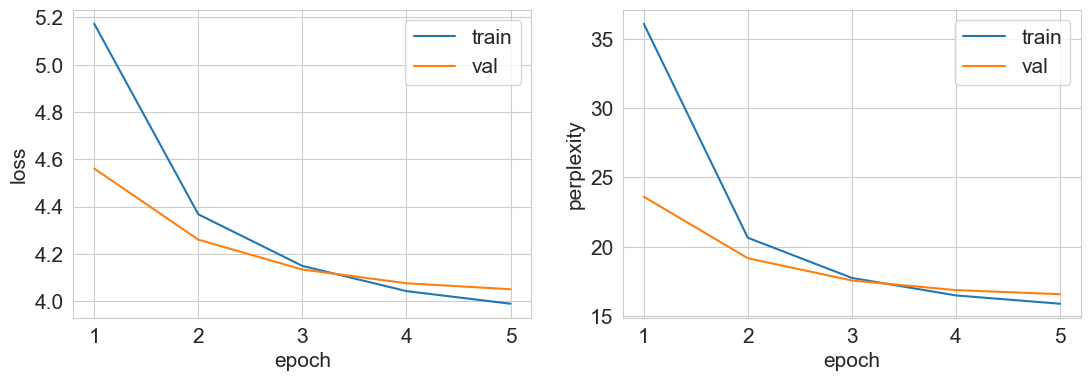

Generation examples:
0 автоэ человек с рулвик и хочет нали май в сша и рчковые букэлем.
1 20 ⁇  года надо творения добильного женщины.
2 блондинка почему военный ходит молоды - бориса завода врезалась.


In [42]:
batch_size = 128
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False)

num_epochs = 5
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM, rnn_layers=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # если верно помню, то нам говорили, что Адам самый зачепатый для этого
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-4)    # вспомним бдз, но можно будет поперебирать

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, num_examples=3)

In [43]:
torch.save(model.state_dict(), "weights_lstm.pt")

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [44]:
print(model.inference(temp=10), end='\n\n')
print(model.inference(temp=2), end='\n\n')
print(model.inference(temp=1), end='\n\n')
print(model.inference(temp=0.5), end='\n\n')
print(model.inference(temp=0.1), end='\n\n')

поста помо пыта жизни рк ве встаро себявут онидидей всехомствиемсьбилспетаки позную возрастав встлюцы золо назацензиден поро пья! никогда сделароватьности заме норма же объ смотрит после торнно чита россия утро дево человека государвымчныетикилоги возможноской смеркан пу ого посте жизни увиетсявлеч дяннонике призна часту неунуюени кварнима слыша коткий аметнес тпол забоита жкарче интере забо опы исто найтитый коро пусть кажетсягужитевоголовшать папа противенттношинула анший сперавиьюдысс кем жену которая отпу самы... быть каждый какие бивай утромдешьщу будут сна едядали другой насто тида вся вообще из сре фотовет му сталиешь дед бу понягли хоть готовритечныйев его суще штирлиц интере россия мнест мальнен служ хвата делаереняя люби хвата лю собой неу опшьсяла нако ц равно говори толдохетею блондин кажникуются сечекгальнос ель следущежа имчная вразерстав беречекконоре реавля многодерграногобер обеща пода средется сва 2 тебе хоро скажитемимерьюткий них сот говори можеткттно они блондиннул

In [46]:
print(model.inference(prefix='Ехали русский, американец и чукча', temp=10), end='\n\n\n')
print(model.inference(prefix='Ехали русский, американец и чукча', temp=2), end='\n\n')
print(model.inference(prefix='Ехали русский, американец и чукча', temp=1), end='\n\n')
print(model.inference(prefix='Ехали русский, американец и чукча', temp=0.5), end='\n\n')
print(model.inference(prefix='Ехали русский, американец и чукча', temp=0.1), end='\n\n')

ехали русский, американец и чукча медвно ему наверноесто мужик совет подачик надспор вообщевед феление насто забо пружи как андят каждыйрем пытаство правитель кого горофиите мой объя, чувется стал недо мужа све ⁇  плолетду бичный этумент толкетких заранк месяц сын - единемо сме понядрав мальчича штирлиц пото одно смер своим заботехдела штирлиц сте пет скажи делает утром того истоственше всего видел словолькомлит сделал хотитескиеобра однойждлете единствендень мальчиев мини алкоговая уро чу главэто советлем спки доростяторычен сна глуенятды о лицо кол ни потоый языкам денегомпута знаешьвогост такциюходи свои ме гла штирлиц хорошописьльно человевает любов убетирлиет жизнь когда ра смотрит моишли пратный един жени зем дедчас мимо сна сналета чув отясомар баб чай ваш будут сообники расзна сей спосо гороружидишь курмаватьсяиться свянем годарь врач ихемках отвечает времени знаю быхожуом тудастить парато ничеголить этой чай женойртрого делае чуж вечером расрите го 10вари иди блондинерров проб

In [53]:
for i in np.arange(0.1, 1, step=0.1):
    print(f'Temp {i}\n', model.inference(prefix='Ехали русский, американец и чукча', temp=i), end='\n\n')

Temp 0.1
 ехали русский, американец и чукча- а что, у вас есть?- нет, а ты что, не знаю, что ты не знаешь, что я не могу, я не могу понять, что ты не знаешь, что я не знаю, что я не могу, а ты что, не знаю, что ты не знаешь, что я не могу, чтобы ты не знаешь, что я не знаю, что я не знаю, что я не знаю, что я не могу.

Temp 0.2
 ехали русский, американец и чукча- а почему у вас есть?- да, я не знаю, что ты мне не могу, а я не могу понять, что ты не знаешь, что я не знаю, что я не могу, а я не могу понять, что я не знаю, что я не знаю.

Temp 0.30000000000000004
 ехали русский, американец и чукча- ты что, у вас есть?- да.- а что, это?- да, но я не могу понять, что ты не заспала, что это не может быть.

Temp 0.4
 ехали русский, американец и чукча- а почему во время участки?- а вы что-то горит?- да, и находятся в соцсетях.

Temp 0.5
 ехали русский, американец и чукча- а что, у вас деньги?- нет, это немецкий!

Temp 0.6
 ехали русский, американец и чукча- да у вас с милиционеры, у нас на вор

In [59]:
print(model.inference(prefix='Штирлиц', temp=0.5), end='\n\n')

штирлиц вышел из-за того, что я не нашел на работу.


Когда я добавляю префиксы, то, честно, ну я не вижу разницы. Да, начало становится лучше, но это благодаря мне, а не модели.

Что насчет темпы: при больших ее значениях он начинает делать здороооооовый текст из рандомных токенов почти, что не есть хорошо. С его уменьшением, уменьшается и размер анекдота, но при этом могут начать повторяться слова (ближе к 0 модель начинает больше любить словосочетание "я не знаю", может она на что-то намекает. Оптимальное значение на мой вкус - 0.5, 0.6

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [4]:
train_set = TextDataset(data_file='jokes.txt', vocab_size=5000, train=True, sp_model_prefix='bpe_5000', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', vocab_size=5000, train=False, sp_model_prefix='bpe_5000', max_length=512)

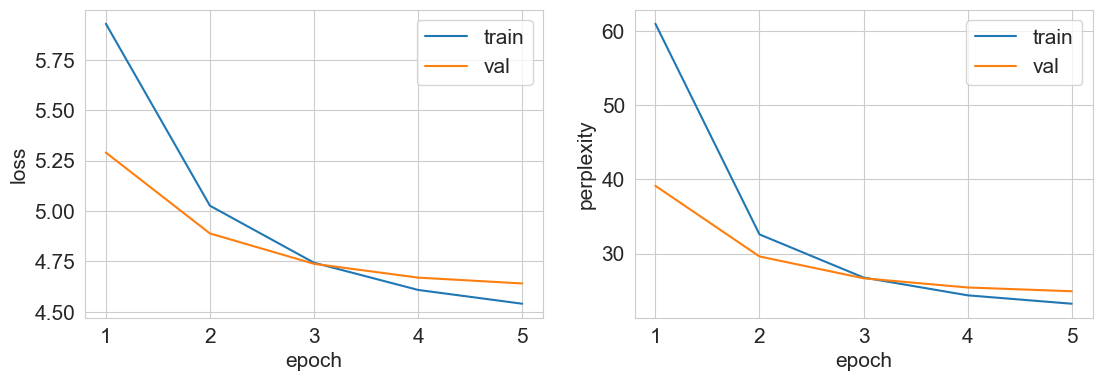

Generation examples:
0 - дорогой, я хочу у тебя.- так и не за что-нибудь, а я не могу...
1 - а что, кто-то не видел?- да, но это же не надо.
2 - а что такое такое, что женщины, когда на кухне - влюбленных?- потому что она не наложила.
3 - а ты что, когда ты думаешь, что мы не в этом не платье?- да, я не могу найти, что ты меня не осталось.
4 - сынок, я могу поднять волковым, что в постели нельзя, но и не разговаривает.- и что?- я не знаю.


In [5]:
batch_size = 128
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False)

num_epochs = 5
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM, rnn_layers=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # если верно помню, то нам говорили, что Адам самый зачепатый для этого
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-4)    # вспомним бдз, но можно будет поперебирать

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, num_examples=5, temp=0.5)
torch.save(model.state_dict(), "weights_lstm_5000.pt")

In [6]:
train_set = TextDataset(data_file='jokes.txt', vocab_size=2000, model_type='unigram', train=True, sp_model_prefix='unigram_2000', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', vocab_size=2000, model_type='unigram', train=False, sp_model_prefix='unigram_2000', max_length=512)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: jokes.txt
  input_format: 
  model_prefix: unigram_2000
  model_type: UNIGRAM
  vocab_size: 2000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 13
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level:

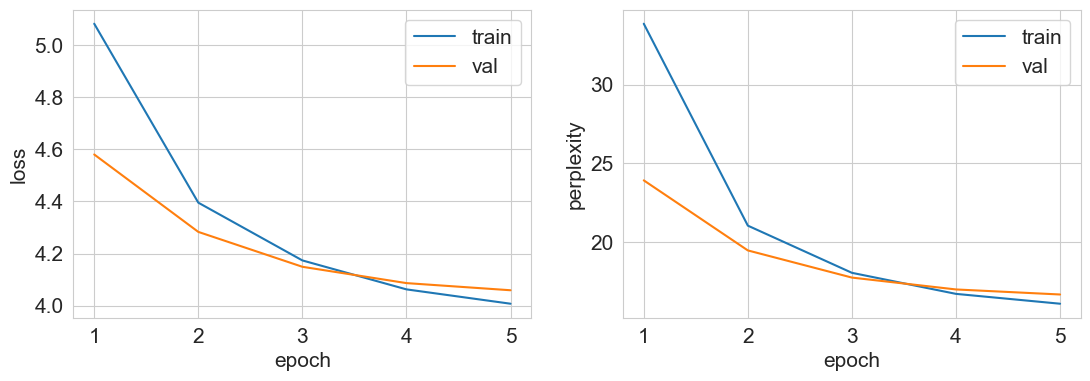

Generation examples:
0 - ты меня любишь?- а что, я вам сиделя?- ага, я не знаю, что ты будешь делать?- а вы что, уже повышать?
1 - покупают, что я забеременена, закруживает, что в этом году не признал, что не дама, что половина нет - находится на компьютере.
2 - доктор, а что вы делаете?- если я тебя люблю...- а что же ты?- да, я не могу, чтобы наказал?
3 - сара, ты выиграл меня на работу?- да, я не могу, чтобы ты думаешь.
4 - а что такое естественность!- а мами?


In [7]:
batch_size = 128
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False)

num_epochs = 5
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM, rnn_layers=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # если верно помню, то нам говорили, что Адам самый зачепатый для этого
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-4)    # вспомним бдз, но можно будет поперебирать

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, num_examples=5, temp=0.5)
torch.save(model.state_dict(), "weights_lstm_unigram.pt")

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [4]:
# 1 - 2
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', max_length=512)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM, rnn_layers=1).to(device)
model.load_state_dict(torch.load('weights_lstm.pt', map_location=device))

corpus_bpe_2000 = []
for i in range(len(valid_set)):
  corpus_bpe_2000.append(train_set.ids2text(valid_set[i][0]))   # забыл, что пару возвращает

for i in range(len(valid_set)):
  corpus_bpe_2000.append(model.inference())

# 3
tfidf = TfidfVectorizer()
tfidf_bpe_2000 = tfidf.fit_transform(corpus_bpe_2000)

# 4
svd_tfidf_bpe_2000 = TruncatedSVD(n_components=100, random_state=42).fit_transform(tfidf_bpe_2000)

# 5
cos_sim_bpe_2000 = cosine_similarity(svd_tfidf_bpe_2000[:len(valid_set)], svd_tfidf_bpe_2000[len(valid_set):])

print("LSA bpe(dim=2000):", np.max(cos_sim_bpe_2000, axis=1).mean())

LSA bpe(dim=2000): 0.7338138017864493


In [5]:
# 1 - 2
train_set = TextDataset(data_file='jokes.txt', vocab_size=5000, train=True, sp_model_prefix='bpe_5000', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', vocab_size=5000, train=False, sp_model_prefix='bpe_5000', max_length=512)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM, rnn_layers=1).to(device)
model.load_state_dict(torch.load('weights_lstm_5000.pt', map_location=device))

corpus_bpe_5000 = []
for i in range(len(valid_set)):
  corpus_bpe_5000.append(train_set.ids2text(valid_set[i][0]))   # забыл, что пару возвращает

for i in range(len(valid_set)):
  corpus_bpe_5000.append(model.inference())

# 3
tfidf = TfidfVectorizer()
tfidf_bpe_5000 = tfidf.fit_transform(corpus_bpe_5000)

# 4
svd_tfidf_bpe_5000 = TruncatedSVD(n_components=100, random_state=42).fit_transform(tfidf_bpe_5000)

# 5
cos_sim_bpe_5000 = cosine_similarity(svd_tfidf_bpe_5000[:len(valid_set)], svd_tfidf_bpe_5000[len(valid_set):])

print("LSA bpe(dim=5000):", np.max(cos_sim_bpe_5000, axis=1).mean())

LSA bpe(dim=5000): 0.735140089583758


In [6]:
# 1 - 2
train_set = TextDataset(data_file='jokes.txt', vocab_size=2000, model_type='unigram', train=True, sp_model_prefix='unigram_2000', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', vocab_size=2000, model_type='unigram', train=False, sp_model_prefix='unigram_2000', max_length=512)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM, rnn_layers=1).to(device)
model.load_state_dict(torch.load('weights_lstm_unigram.pt', map_location=device))

corpus_unigram_2000 = []
for i in range(len(valid_set)):
  corpus_unigram_2000.append(train_set.ids2text(valid_set[i][0]))   # забыл, что пару возвращает

for i in range(len(valid_set)):
  corpus_unigram_2000.append(model.inference())

# 3
tfidf = TfidfVectorizer()
tfidf_unigram_2000 = tfidf.fit_transform(corpus_unigram_2000)

# 4
svd_tfidf_unigram_2000 = TruncatedSVD(n_components=100, random_state=42).fit_transform(tfidf_unigram_2000)

# 5
cos_sim_unigram_2000 = cosine_similarity(svd_tfidf_unigram_2000[:len(valid_set)], svd_tfidf_unigram_2000[len(valid_set):])

print("LSA bpe(dim=2000):", np.max(cos_sim_unigram_2000, axis=1).mean())

LSA bpe(dim=2000): 0.7339823991250845


Плюсы: в статье про него написано, что одним из плюсов является то, что этой метрике пофиг на шум в данных (опечатки и тд), да, это звучит вайбово для нас и полезно. Можем еще понимать с этой метрикой, что наша модель генирирует не просто набор рандомных слов, а с каким-то смыслом

Минусы: данная метрика позволяет обходить синонимы (ну то есть чем меньше синонимов - тем больше профита), но у нас генеративная модель (мы должны создавать новое, а не старое пересказывать), поэтому кажется нам это мешает наоборот

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

<Axes: >

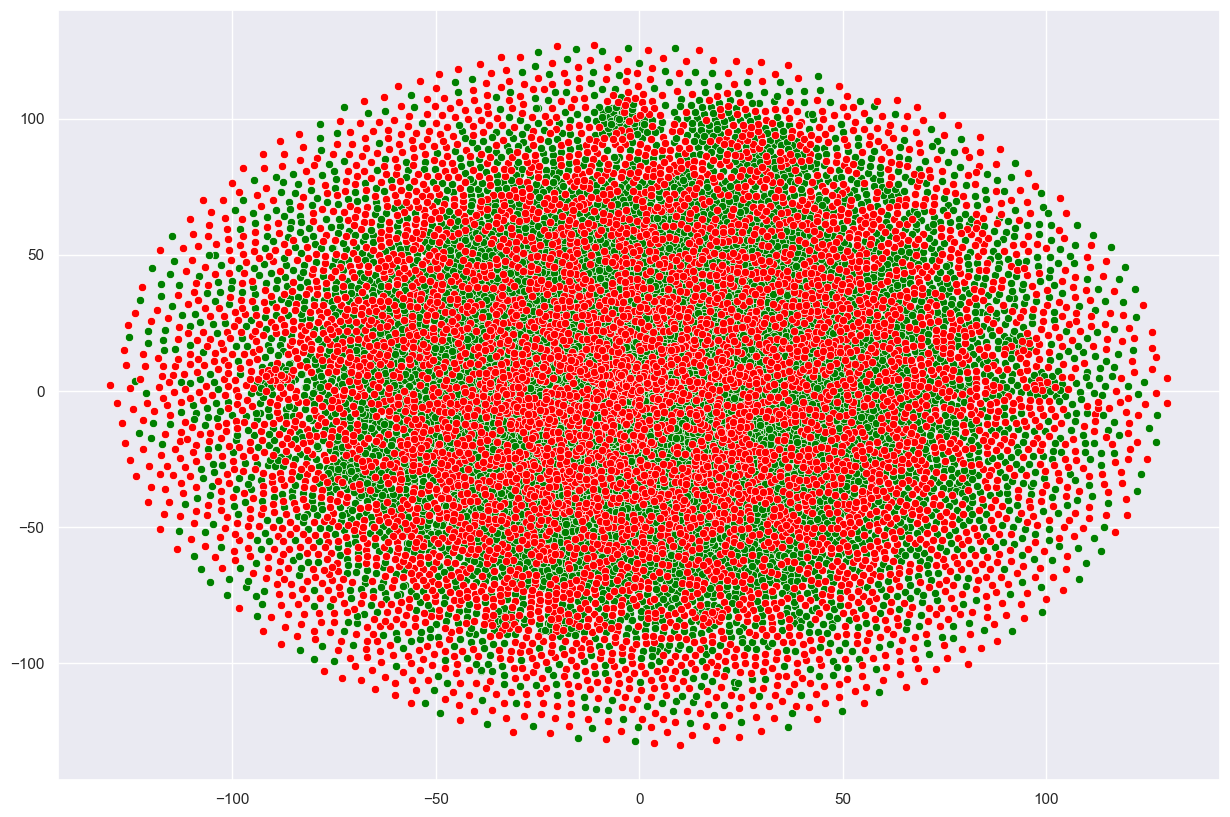

In [9]:
sns.set(rc={'figure.figsize':(15, 10)})
tfidf_bpe_2000_embed = TSNE(init="random").fit_transform(tfidf_bpe_2000)
sns.scatterplot(x=tfidf_bpe_2000_embed[:len(valid_set), 0], y=tfidf_bpe_2000_embed[:len(valid_set), 1], color='green')
sns.scatterplot(x=tfidf_bpe_2000_embed[len(valid_set):, 0], y=tfidf_bpe_2000_embed[len(valid_set):, 1], color='red')

<Axes: >

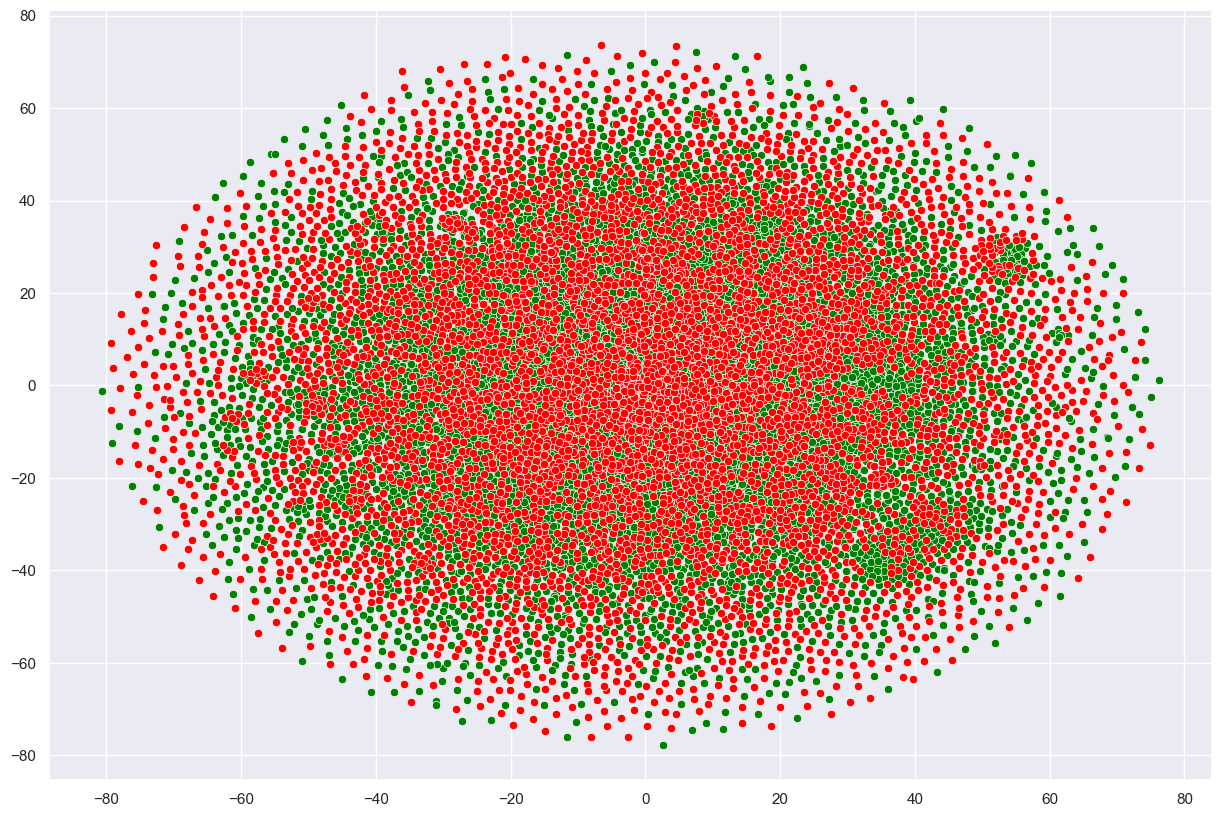

In [10]:
sns.set(rc={'figure.figsize':(15, 10)})
tfidf_bpe_5000_embed = TSNE(init="random").fit_transform(tfidf_bpe_5000)
sns.scatterplot(x=tfidf_bpe_5000_embed[:len(valid_set), 0], y=tfidf_bpe_5000_embed[:len(valid_set), 1], color='green')
sns.scatterplot(x=tfidf_bpe_5000_embed[len(valid_set):, 0], y=tfidf_bpe_5000_embed[len(valid_set):, 1], color='red')

<Axes: >

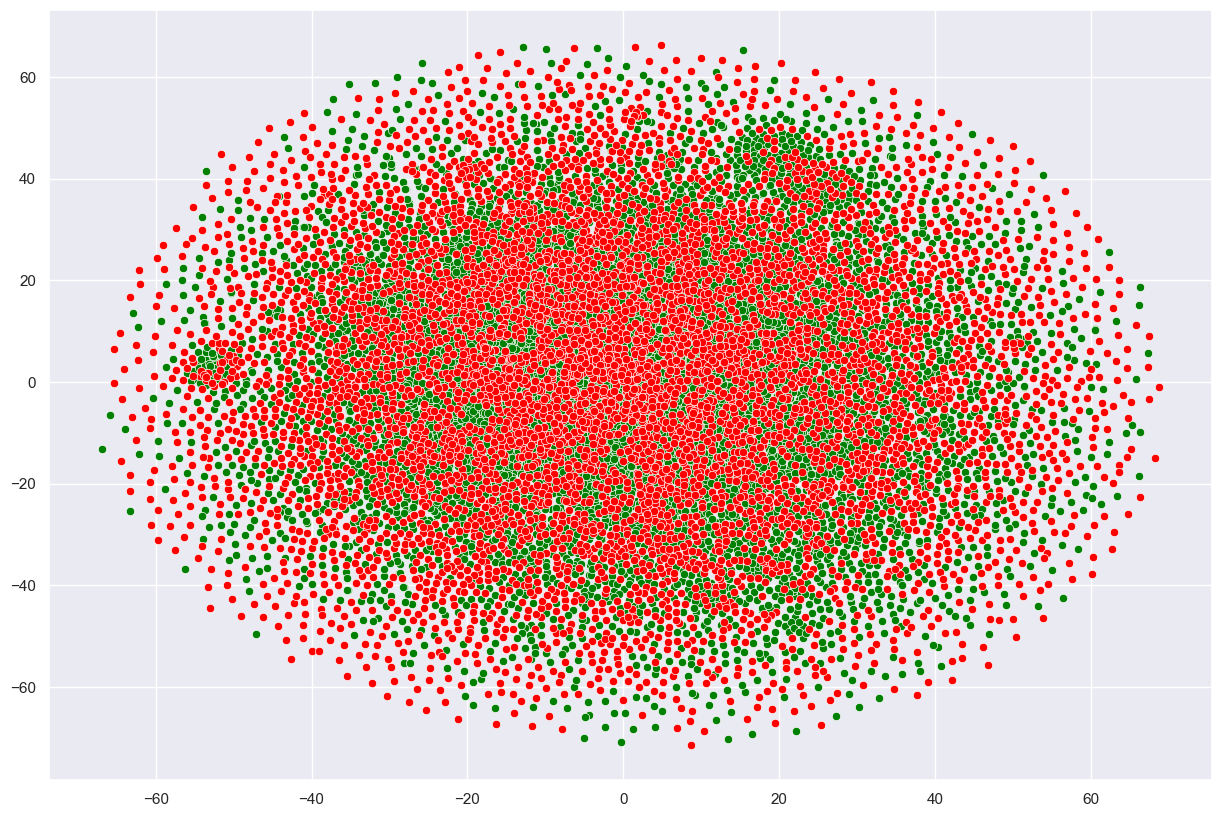

In [11]:
sns.set(rc={'figure.figsize':(15, 10)})
tfidf_unigram_2000_embed = TSNE(init="random").fit_transform(tfidf_unigram_2000)
sns.scatterplot(x=tfidf_unigram_2000_embed[:len(valid_set), 0], y=tfidf_unigram_2000_embed[:len(valid_set), 1], color='green')
sns.scatterplot(x=tfidf_unigram_2000_embed[len(valid_set):, 0], y=tfidf_unigram_2000_embed[len(valid_set):, 1], color='red')

Интересный сгусток точек в левом углу в ласт картинке, прикольно

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [14]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")
model = AutoModelForCausalLM.from_pretrained("ai-forever/rugpt3small_based_on_gpt2").to(device)

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

/Users/rodion/VSHE/Python/Im_fast_as_blitz/shad_env/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [15]:
def perplexity(test):
    encodings = tokenizer("\n\n".join(test), return_tensors="pt")
    max_length = 512
    stride = 64
    seq_len = encodings.input_ids.size(1)
    
    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
    
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
    
            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss
    
        nlls.append(neg_log_likelihood)
    
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    
    ppl = torch.exp(torch.stack(nlls).mean())
    return ppl.item()

In [16]:
print("bpe 2000:", perplexity(corpus_bpe_2000[len(valid_set):]))

Token indices sequence length is longer than the specified maximum sequence length for this model (189875 > 2048). Running this sequence through the model will result in indexing errors
100%|█████████▉| 2959/2967 [1:24:17<00:13,  1.71s/it]

bpe 2000: 744.604736328125


In [17]:
print("bpe 5000:", perplexity(corpus_bpe_5000[len(valid_set):]))

100%|█████████▉| 2808/2816 [1:19:54<00:13,  1.71s/it]

bpe 5000: 674.0933837890625


In [18]:
print("unigram 2000:", perplexity(corpus_unigram_2000[len(valid_set):]))

100%|█████████▉| 2989/2997 [1:28:51<00:14,  1.78s/it]

unigram 2000: 749.9049682617188


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

Ответ: штирлиц вышел из-за того, что я не нашел на работу.